In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import sys
import math
import pandas as pd
import numpy as np
from numpy import *
import scipy.stats as stats
from scipy.io import loadmat
import random
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
class TreeNode:
    def __init__(self, attribute):
        self.attribute = attribute
        self.children = {}

    def display(self, level = 0):
        if self.children == {}: 
            print(": ", self.attribute, end="")
        else:
            for value in self.children.keys():
                prefix = "\n" + " " * level * 4
                print(prefix, self.attribute, "=", value, end="")
                self.children[value].display(level + 1)
     
    def predicts(self, root, catAtt):
        if self.children == {}: 
            return self.attribute
        if self.attribute in catAtt:
            value = root[self.attribute]
            if value in self.children:
                subtree = self.children[value]
                return subtree.predicts(root, catAtt)
            else:
                return 0
        else:
            val = 0
            for val1 in self.children.keys():
                val = val1
            feature_name, comparison_operator, value, pos = val.split(" ")
            if root[feature_name] <= float(value):
                Question = "{} <= {} left".format(feature_name, value)
                subtree = self.children[Question]
            else:
                Question = "{} <= {} right".format(feature_name, value)
                subtree = self.children[Question]
            
            return subtree.predicts(root, catAtt)

In [5]:
def CountTotalLabels(labelData):
    positive, negative = 0, 0
    for label in labelData:
        if label == 0:
            positive += 1
        else:
            negative += 1
    return positive, negative

In [6]:
def giniIndex(examples, target):
    positive, negative = CountTotalLabels(examples[target])
    Total = positive + negative
    positive = positive / Total
    negative = negative / Total
    giniIndex = positive * positive + negative * negative
    return (1 - giniIndex)

In [7]:
def getEntropy(examples, target):
    positive, negative = CountTotalLabels(examples[target])
    logv = log(2)
    logv = logv * (positive + negative)
    Entropy = 0.0
    if not positive == 0:
        Entropy = positive * (-log(positive/(positive + negative)))/logv
    if not negative == 0:
        Entropy = Entropy + negative * (-log(negative/(positive + negative)))/logv
    return Entropy

In [8]:
def get_potential_splits(data):
    unique_values = np.unique(data)
    potential_splits = []
    unique_values.sort()
    for index in range(len(unique_values)):
        if index != 0:
            current_value = unique_values[index]
            previous_value = unique_values[index - 1]
            potential_split = (current_value + previous_value) / 2
            potential_splits.append(potential_split)
    
    return potential_splits

In [9]:
def split_data(data, split_column, split_value):
    
    split_column_values = data[split_column]

    data_below = data[split_column_values <= split_value]
    data_above = data[split_column_values >  split_value]
    
    return data_below, data_above

In [10]:
def getBestAttribute(examples, target, attributes, trainData, infoFunction):
    baseEntropy = infoFunction(examples, target)
    TotalLength = len(examples)
    informationGain = []
    
    for attribute in attributes:
        unique_values = np.unique(trainData[attribute])
        if len(unique_values) < 3 or (len(unique_values) >= 3 and isinstance(unique_values[0], str)):
            groupedData = examples.groupby(attribute)
            totalEntropy = 0
            for key,exampleSubset in groupedData:
                del exampleSubset[attribute]
                entropyOfSubset = infoFunction(exampleSubset,target)
                totalEntropy += (len(exampleSubset)/ TotalLength)*entropyOfSubset
            informationGain.append([attribute, baseEntropy-totalEntropy, key])
        else:
            potential_splits = get_potential_splits(examples[attribute])
            totalEntropy, val, overall_entropy = 0, 0, 999
            for value in potential_splits:
                data_below, data_above = split_data(examples, split_column=attribute, split_value=value)
                n = len(data_below) + len(data_above)
                totalEntropy =  ((len(data_below) / n) * infoFunction(data_below, target) 
                                  + (len(data_above) / n) * infoFunction(data_above, target))
                if totalEntropy <= overall_entropy:
                    overall_entropy = totalEntropy
                    val = value
            informationGain.append([attribute,baseEntropy-overall_entropy,val])

    bestAttribute = max(informationGain, key=lambda x: x[1])
    return bestAttribute[0], bestAttribute[2]

In [11]:
def classify_data(examples, target, attributes, max_level):
    if len(attributes) == 0 or max_level == 1:
        item_counts = examples[target].value_counts()
        max_item = item_counts.idxmax()
        return max_item
    else:
        return False

In [12]:
def data_purity(examples, target):
    uniques = examples.apply(lambda x: x.nunique()).loc[target]
    if uniques == 1:
        return True
    else:
        return False

In [13]:
def decisionTree(examples, target, attributes1, trainData, infoFunction, max_level = 15):
    global Nodes
    Nodes += 1
    attributes = attributes1[:] # Make it as Local
    if data_purity(examples, target):
        return TreeNode(examples[target].iloc[0])

    max_item = classify_data(examples, target, attributes, max_level)
    if len(attributes) == 0 or max_level == 1:
        return TreeNode(max_item)
    
    
    bestAttribute, bestValue = getBestAttribute(examples, target, attributes, trainData, infoFunction)
    attributeRoot = TreeNode(bestAttribute)
    
    unique_values = np.unique(trainData[bestAttribute])
    if len(unique_values) < 6 or (len(unique_values) >= 6 and isinstance(unique_values[0], str)):
        attributes.remove(bestAttribute)
        groupedData = examples.groupby(bestAttribute)
        for key,exampleSubset in groupedData:
                if len(exampleSubset) == 0:
                    item_counts = exampleSubset[target].value_counts()
                    max_item = item_counts.idxmax()
                    attributeRoot.children[key] = TreeNode(max_item)
                else:
                    attributeRoot.children[key] = decisionTree(exampleSubset.drop([bestAttribute],axis=1), 
                                                               target, attributes, trainData, infoFunction, max_level - 1)
    else:
        data_below, data_above = split_data(examples, split_column=bestAttribute, split_value=bestValue)

        if len(data_below) == 0 or len(data_above) == 0 or max_level == 1:
            attributes.remove(bestAttribute)
            item_counts = examples[target].value_counts()
            max_item = item_counts.idxmax()
            return TreeNode(max_item) 
        
        key = "{} <= {} left".format(bestAttribute, bestValue)
    
        attributeRoot.children[key] = decisionTree(data_below, target, attributes, trainData, infoFunction, max_level - 1)
        key = "{} <= {} right".format(bestAttribute, bestValue)

        attributeRoot.children[key] = decisionTree(data_above, target, attributes, trainData, infoFunction, max_level - 1)

    return attributeRoot

In [14]:
def train_test_split(df, test_size):
    if isinstance(test_size, float):
        test_size = round(test_size * len(df))
    indices = df.index.tolist()
    test_indices = random.sample(population=indices, k=test_size)
    
    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)
    return train_df, test_df

In [15]:
def EvaluatingTree(tree, test, target, catAtt):
    correct = 0
    TP, FN, FP = 0,0,0
    for i in range(0, len(test)):
        if str(tree.predicts(test.loc[i], catAtt)) == str(test.loc[i,target]):
            correct += 1
            if(test.loc[i, target] == 0):
                FP += 1
            else:
                TP += 1
        else:
            if(test.loc[i, target] == 0):
                FN += 1
    print("\nThe accuracy is: ", correct/len(test))
    X = TP + FN
    Y = TP + FP
    Recall, Precision = 1, 1
    if X:
        Recall = TP/ X
    if Y:
        Precision = TP/ Y
    print("\nRecall is : ", Recall)
    print("\nPrecision is : ", Precision)
    if Precision or Recall:
        print("\nF1 Score is : ", (2 * (Recall * Precision))/ (Recall + Precision))

In [16]:
df = pd.read_csv("/content/gdrive/My Drive/Prakrati/dataset/dataset3.csv")
df = df.drop(['No'], axis=1)
print("Data Length: ", len(df))
df = df.dropna()
print("Data Length after removing NaN values: ", len(df))
print(df.head())
target = "month"
print(np.unique(df['year']))
train, test = train_test_split(df, test_size = 0.2)
test = test.reset_index()
train = train.reset_index()

attributes = train.columns.tolist()
attributes.remove(target)
catAtt = ['year', 'cbwd']

Data Length:  43824
Data Length after removing NaN values:  41757
    year  month  day  hour  pm2.5  DEWP  TEMP    PRES cbwd   Iws  Is  Ir
24  2010      1    2     0  129.0   -16  -4.0  1020.0   SE  1.79   0   0
25  2010      1    2     1  148.0   -15  -4.0  1020.0   SE  2.68   0   0
26  2010      1    2     2  159.0   -11  -5.0  1021.0   SE  3.57   0   0
27  2010      1    2     3  181.0    -7  -5.0  1022.0   SE  5.36   1   0
28  2010      1    2     4  138.0    -7  -5.0  1022.0   SE  6.25   2   0
[2010 2011 2012 2013 2014]


In [39]:
global Nodes
Nodes = 0
treeEn = decisionTree(train, target, attributes, train, getEntropy)

In [46]:
EvaluatingTree(treeEn, test, target, catAtt)


The accuracy is:  0.08542102742186565

Recall is :  1.0

Precision is :  1.0

F1 Score is :  1.0


In [41]:
Nodes = 0
treeGini = decisionTree(train, target, attributes, train, giniIndex)

In [42]:
EvaluatingTree(treeGini, test, target, catAtt)


The accuracy is:  0.08442102742186565

Recall is :  1.0

Precision is :  1.0

F1 Score is :  1.0


In [52]:
trainAccEn = []
testAccEn = []
TotalNodesEn = []
for max_level in [2, 4, 8, 10, 15, 30]:
    global Nodes
    Nodes = 0
    treeEn = decisionTree(train, target, attributes, train, getEntropy, max_level)
    TotalNodesEn.append(Nodes)
    trainAccEn.append(EvaluatingTree(treeEn, train, target, catAtt))
    testAccEn.append(EvaluatingTree(treeEn, test, target, catAtt))
    print("Completed Decision Tree for Entropy gain for Level: ", max_level)


The accuracy is:  0.0892176854457283

Recall is :  1.0

Precision is :  1.0

F1 Score is :  1.0

The accuracy is:  0.08494204286911747

Recall is :  1.0

Precision is :  1.0

F1 Score is :  1.0
Completed Decision Tree for Entropy gain for Level:  2

The accuracy is:  0.08927755493025205

Recall is :  1.0

Precision is :  1.0

F1 Score is :  1.0

The accuracy is:  0.08506178900730452

Recall is :  1.0

Precision is :  1.0

F1 Score is :  1.0
Completed Decision Tree for Entropy gain for Level:  4

The accuracy is:  0.08939729389929953

Recall is :  1.0

Precision is :  1.0

F1 Score is :  1.0

The accuracy is:  0.08506178900730452

Recall is :  1.0

Precision is :  1.0

F1 Score is :  1.0
Completed Decision Tree for Entropy gain for Level:  8

The accuracy is:  0.08945716338382327

Recall is :  1.0

Precision is :  1.0

F1 Score is :  1.0

The accuracy is:  0.08506178900730452

Recall is :  1.0

Precision is :  1.0

F1 Score is :  1.0
Completed Decision Tree for Entropy gain for Level: 

In [62]:
trainAccEn = [0.0892176854457283, 0.08927755493025205, 0.08939729389929953, 0.08945716338382327, 0.0896068370951326, 0.09005585822906065]
testAccEn = [0.08494204286911747, 0.08506178900730452, 0.08506178900730452, 0.08506178900730452, 0.08542102742186565, 0.08590001197461382]

In [58]:
TotalNodesEn

[3, 7, 15, 19, 29, 59]

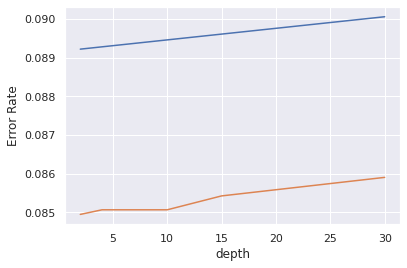

In [63]:
depth = np.array([2, 4, 8, 10, 15, 30])
plt.plot(depth, trainAccEn)
plt.plot(depth, testAccEn)
plt.xlabel('depth')
plt.ylabel('Error Rate')
plt.show()

In [17]:
treeEn = []
TotalNodesEn = []
for max_level in np.arange(1, 100, 1):
    train, test = train_test_split(df, test_size = 0.5)
    test = test.reset_index()
    train = train.reset_index()

    attributes = train.columns.tolist()
    attributes.remove(target)
    global Nodes
    Nodes = 0
    treeEn.append(decisionTree(train, target, attributes, train, getEntropy, 3))
    TotalNodesEn.append(Nodes)
    print("Completed Decision Tree for Entropy gain: ", max_level)

Completed Decision Tree for Entropy gain:  1
Completed Decision Tree for Entropy gain:  2
Completed Decision Tree for Entropy gain:  3
Completed Decision Tree for Entropy gain:  4
Completed Decision Tree for Entropy gain:  5
Completed Decision Tree for Entropy gain:  6
Completed Decision Tree for Entropy gain:  7
Completed Decision Tree for Entropy gain:  8
Completed Decision Tree for Entropy gain:  9
Completed Decision Tree for Entropy gain:  10
Completed Decision Tree for Entropy gain:  11
Completed Decision Tree for Entropy gain:  12
Completed Decision Tree for Entropy gain:  13
Completed Decision Tree for Entropy gain:  14
Completed Decision Tree for Entropy gain:  15
Completed Decision Tree for Entropy gain:  16
Completed Decision Tree for Entropy gain:  17
Completed Decision Tree for Entropy gain:  18
Completed Decision Tree for Entropy gain:  19
Completed Decision Tree for Entropy gain:  20
Completed Decision Tree for Entropy gain:  21
Completed Decision Tree for Entropy gain:  

In [21]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(treeEn, open(filename, 'wb'))

In [29]:
def EvaluatingTree100(tree, test, target, catAtt, i):
    correct = 0
    for index in range(0, len(tree)):
        if str(tree[index].predicts(test.loc[i], catAtt)) == str(test.loc[i,target]):
            correct += 1
    if correct >= len(tree)/2:
        return 1
    return 0

In [30]:
correct = 0
train, test = train_test_split(df, test_size = 0.5)
test = test.reset_index()
for i in range(0, len(test)):
  correct += EvaluatingTree100(treeEn, test, target, catAtt, i)

print("\nThe accuracy is: ", correct/len(test))


The accuracy is:  0.08789156049430022


In [ ]:
trainAccEn = []
testAccEn = []
treeEn = []
TotalNodesEn = []
for max_level in [4, 8, 10, 15, 20, 30]:
  for i in np.arange(1, 40, 1):
      train, test = train_test_split(df, test_size = 0.5)
      test = test.reset_index()
      train = train.reset_index()

      attributes = train.columns.tolist()
      attributes.remove(target)
      global Nodes
      Nodes = 0
      treeEn.append(decisionTree(train, target, attributes, train, getEntropy, max_level))
      TotalNodesEn.append(Nodes)

  correct = 0
  train, test = train_test_split(df, test_size = 0.5)
  test = test.reset_index()
  for i in range(0, len(train)):
    correct += EvaluatingTree100(treeEn, train, target, catAtt, i)
  trainAccEn.append(correct/len(train))

  print("\nThe train accuracy for ", max_level, "is: ", correct/len(train))

  for i in range(0, len(test)):
    correct += EvaluatingTree100(treeEn, test, target, catAtt, i)
  testAccEn.append(correct/len(test))

  print("\nThe test accuracy for ", max_level, "is: ", correct/len(test))